<a href="https://colab.research.google.com/github/howsmyanimeprofilepicture/nerf-torch/blob/main/NeRF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch.nn as nn
import torch
from torch.distributions import Uniform
from typing import Tuple, NamedTuple, Iterable

import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from dataclasses import dataclass, field

In [2]:
# @title utils
def set_seed(seed: int) -> None:
    torch.manual_seed(seed)
    np.random.seed(seed)


@dataclass
class Config:
    data_path: str = "tiny_nerf_data.npz"
    near_thresh: float = 2.0
    far_thresh: float = 6.0
    num_samples: int = 32
    lr: float = 5e-3
    num_iters: int = 1000
    seed: int = 9458
    filter_size: int = 256
    L_origin: int = 10
    L_direction: int = 4
    train_test_split_ratio: float = 0.9
    dtype: torch.dtype = torch.float32
    device: torch.device = field(
        default_factory=lambda: (
            "cuda"
            if torch.cuda.is_available()
            else "cpu"
        )
    )


@dataclass
class NerfData:
    img_train: torch.Tensor
    pose_train: torch.Tensor
    focal_length: torch.Tensor
    img_test: torch.Tensor
    pose_test: torch.Tensor
    height: int
    width: int
    device: torch.device

    @property
    def H(self):
        return self.height

    @property
    def W(self):
        return self.width

    def sample_trainset(self):
        """sample image and pose matrix"""
        idx = np.random.randint(self.img_train.shape[0])

        target_img = self.img_train[idx].to(self.device)
        target_pose = self.pose_train[idx].to(self.device)
        return (target_img,
                target_pose)

    def sample_testset(self):
        """sample image and pose matrix"""
        idx = np.random.randint(self.img_test.shape[0])

        target_img = self.img_test[idx].to(self.device)
        target_pose = self.pose_test[idx].to(self.device)
        return (target_img,
                target_pose)


def load_nerf_dataset(config: Config) -> NerfData:
    data = np.load(config.data_path)
    N: int = data["images"].shape[0]
    num_train = int(config.train_test_split_ratio * N)
    indice = np.arange(N)
    np.random.shuffle(indice)
    train_idx = indice[:num_train]
    test_idx = indice[num_train:]

    pose_train = torch.from_numpy(   # Camera extrinsics (poses)
        data["poses"][train_idx]
    )
    pose_test = torch.from_numpy(          # Camera extrinsics (poses)
        data["poses"][test_idx]
    )

    focal_length = torch.from_numpy(      # Focal length (intrinsics)
        data["focal"]
    )

    img_train = torch.from_numpy(
        data["images"][train_idx]
    )
    img_test = torch.from_numpy(
        data["images"][test_idx]
    )

    _, H, W, _ = img_train.shape

    return NerfData(img_train,
                    pose_train,
                    focal_length,
                    img_test,
                    pose_test,
                    H,
                    W,
                    config.device)


def positional_encoder(tensor: torch.Tensor,
                       L: int) -> torch.Tensor:
    encoding = [tensor]
    frequency_bands = 2.0 ** torch.arange(
        0,
        L,
        dtype=tensor.dtype,
        device=tensor.device,
    )

    for freq in frequency_bands:
        encoding.append(torch.sin(tensor * freq))
        encoding.append(torch.cos(tensor * freq))

    return torch.cat(encoding, dim=-1)


In [13]:
#@title NerfModel.py


class Nerf(torch.nn.Module):

    def __init__(self, config: Config):

        super(Nerf, self).__init__()
        self.config = config
        origin_enc_dim: int = (
            3 + 3 * 2 * config.L_origin
        )
        dir_enc_dim: int = (
            3 + 3 * 2 * config.L_direction
        )

        self.layer1 = nn.Sequential(
            nn.Linear(
                origin_enc_dim,
                config.filter_size
            ),
            nn.ReLU(),
            nn.Linear(
                config.filter_size,
                config.filter_size
            ),
            nn.ReLU(),
            nn.Linear(
                config.filter_size,
                config.filter_size
            ),
            nn.ReLU(),
            nn.Linear(
                config.filter_size,
                config.filter_size
            ),
            nn.ReLU(),
        )

        self.layer2 = nn.Sequential(
            nn.Linear(origin_enc_dim + config.filter_size,
                      config.filter_size),
            nn.ReLU(),
            nn.Linear(config.filter_size,
                      config.filter_size),
            nn.ReLU(),
            nn.Linear(config.filter_size,
                      config.filter_size),
            nn.ReLU(),
            nn.Linear(config.filter_size,
                      config.filter_size + 1),
        )

        self.layer3 = nn.Sequential(
            nn.Linear(config.filter_size + dir_enc_dim,
                      config.filter_size//2),
            nn.ReLU(),
            nn.Linear(config.filter_size//2,
                      3),
        )
        self.to(device=config.device)

    def forward(self,
                r_vals: torch.Tensor,
                d_vals: torch.Tensor
                ) -> Tuple[torch.Tensor, torch.Tensor]:

        (H, W, num_samples, C) = r_vals.size()
        assert r_vals.size() == d_vals.size() and C == 3
        r_vals = r_vals.reshape(-1, 3)
        d_vals = d_vals.reshape(-1, 3)

        L_o = self.config.L_origin
        L_d = self.config.L_direction

        r_vals = positional_encoder(r_vals, L_o)
        d_vals = positional_encoder(d_vals, L_d)

        h = self.layer1(r_vals)
        h_and_sigma = self.layer2(torch.cat([h, r_vals],
                                  dim=-1))
        h = h_and_sigma[..., :-1]
        sigma = h_and_sigma[..., -1]
        sigma = F.relu(sigma)
        sigma = sigma.reshape(H, W, num_samples)

        rgb = self.layer3(torch.cat([h, d_vals],
                                    dim=-1))
        rgb = torch.sigmoid(rgb)
        rgb = rgb.reshape(H, W, num_samples, 3)

        return (rgb, sigma)


In [4]:
#@title get_rays.py

class Rays(NamedTuple):
    origins: torch.Tensor
    directions: torch.Tensor


def get_rays(H: int,
             W: int,
             focal_length: float,
             pose: torch.Tensor,
             dtype: torch.dtype,
             device: torch.device,
             ) -> Rays:
    camera_matrix = pose[:3, :3]
    ray_origins = pose[:3, -1]
    assert ray_origins.shape == (3,)
    ray_origins = ray_origins.expand(H, W, 3)

    (ii, jj) = torch.meshgrid(
        torch.arange(W,
                     dtype=dtype,
                     device=device),
        torch.arange(H,
                     dtype=dtype,
                     device=device),
        indexing="xy",
    )
    assert ii.shape == jj.shape == (H,
                                    W)
    ii = (ii - W * .5) / focal_length
    jj = (jj - H * .5) / focal_length

    directions = torch.stack([ii,
                              -jj,
                              -torch.ones_like(ii)],
                             dim=-1)
    assert directions.shape == (H, W, 3)

    ray_directions = directions @ camera_matrix.transpose(1, 0)

    return Rays(ray_origins,
                ray_directions)



In [5]:
#@title get_query_points.py


class QueryPoints(NamedTuple):
    r_vals: torch.Tensor
    d_vals: torch.Tensor
    t_vals: torch.Tensor


def get_t_vals(H: int,
               W: int,
               near_thresh: float,
               far_thresh: float,
               num_samples: int,
               device: str):
    t_vals = torch.linspace(near_thresh,
                            far_thresh,
                            num_samples,
                            device=device)

    noise_shape = (H, W, num_samples,)
    t_vals = (
        t_vals
        + torch.rand(noise_shape).to(device=device)
        * (far_thresh - near_thresh)
        / num_samples
    )
    assert t_vals.shape == noise_shape
    return t_vals


def get_query_points(ray_origins: torch.Tensor,
                     ray_directions: torch.Tensor,
                     t_vals: torch.Tensor,
                     ) -> QueryPoints:
    (H, W, num_samples) = t_vals.shape
    (H, W, C) = ray_origins.shape
    assert ray_origins.shape == ray_directions.shape

    r_vals = (
        # (width, height, 1, 3)
        ray_origins[..., None, :] +
        # (width, height, 1, 3)
        ray_directions[..., None, :]
        # (width, height, depth_samples_per_ray, 1)
        * t_vals[..., :, None]
    )
    assert r_vals.shape == (H, W, num_samples, 3)
    d_vals = ray_directions[..., None, :].expand(
        r_vals.shape
    )
    return QueryPoints(r_vals,
                       d_vals,
                       t_vals)


In [6]:
#@title render_rgb_depth.py

def _cumprod(tensor: torch.Tensor) -> torch.Tensor:
    cumprod = torch.cumprod(tensor, dim=-1)
    # https://pytorch.org/docs/stable/generated/torch.roll.html
    cumprod = torch.roll(cumprod, 1, dims=-1)
    cumprod[..., 0] = 1.
    return cumprod


class RgbInferenceResult(NamedTuple):
    rgb: torch.Tensor
    depth_weights: torch.Tensor


def render_rgb_depth(rgbs: torch.Tensor,
                     sigmas: torch.Tensor,
                     t_vals: torch.Tensor,
                     dtype: torch.dtype,
                     device: torch.device,) -> RgbInferenceResult:

    (H, W, num_samples, C) = rgbs.size()
    assert t_vals.size() == sigmas.size() == (H, W, num_samples)
    one_e_10 = torch.tensor(
        [1e10],
        dtype=dtype,
        device=device
    )
    one_e_10 = one_e_10.expand(t_vals[..., :1].shape)
    deltas = torch.cat([
        t_vals[..., 1:] - t_vals[..., :-1],
        one_e_10
    ],
        dim=-1
    )

    alphas = 1. - torch.exp(-sigmas * deltas)
    transmittance = _cumprod(1. - alphas + 1e-10)
    weights = alphas * transmittance
    assert (weights.size()
            == deltas.size()
            == alphas.size()
            == (H, W, num_samples))
    rgb_pred = (weights[..., None] * rgbs).sum(dim=-2)

    return RgbInferenceResult(
        rgb_pred,
        weights
    )


In [7]:
#@title infer_rgb


def infer_rgb(pose: torch.Tensor,
              nerf_model: Nerf,
              H: int,
              W: int,
              focal_length: float,
              near_thresh: float,
              far_thresh: float,
              num_samples: int,
              dtype: torch.dtype,
              device: torch.device
              ) -> RgbInferenceResult:
    assert pose.shape == (4, 4)
    ray: Rays = get_rays(H,
                         W,
                         focal_length,
                         pose,
                         dtype,
                         device)

    Q: QueryPoints = get_query_points(
        ray.origins,
        ray.directions,
        get_t_vals(H, W, near_thresh,
                   far_thresh, num_samples,
                   device)
    )
    rgbs, sigmas = nerf_model.forward(
        Q.r_vals,
        Q.d_vals
    )

    return render_rgb_depth(
        rgbs,
        sigmas,
        Q.t_vals,
        dtype,
        device,
    )


In [8]:
# @title rendering test



@torch.no_grad()
def rendering_test(config: Config,
                   data: NerfData,
                   nerf_model: Nerf,
                   ):
    t_vals = np.linspace(config.far_thresh,
                         config.near_thresh,
                         config.num_samples)

    (tgt_img,
     tgt_pose) = data.sample_trainset()
    rgb_pred, weights = infer_rgb(
        tgt_pose,
        nerf_model=nerf_model,
        H=data.H,
        W=data.W,
        focal_length=data.focal_length,
        near_thresh=config.near_thresh,
        far_thresh=config.far_thresh,
        num_samples=config.num_samples,
        dtype=config.dtype,
        device=config.device
    )
    _, (ax1, ax2, ax3) = plt.subplots(ncols=3,
                                      figsize=(8, 3))
    ax1.imshow(rgb_pred.detach().cpu())
    weights = weights.detach().cpu()
    ax2.imshow((weights * t_vals).sum(-1))
    ax3.imshow(tgt_img.detach().cpu())
    plt.show()


In [9]:
!wget https://cseweb.ucsd.edu//~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz
data_path = "tiny_nerf_data.npz"

--2023-06-08 22:20:19--  https://cseweb.ucsd.edu//~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz
Resolving cseweb.ucsd.edu (cseweb.ucsd.edu)... 132.239.8.30
Connecting to cseweb.ucsd.edu (cseweb.ucsd.edu)|132.239.8.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12727482 (12M)
Saving to: ‘tiny_nerf_data.npz’

tiny_nerf_data.npz  100%[===================>]  12.14M  7.06MB/s    in 1.7s    

2023-06-08 22:20:22 (7.06 MB/s) - ‘tiny_nerf_data.npz’ saved [12727482/12727482]



In [24]:
config = Config(
    data_path="tiny_nerf_data.npz",
    near_thresh=2.0,
    far_thresh=6.0,
    num_samples=32,
    lr=0.0001,
    num_iters=1000,
    seed=42,
    filter_size=256,
    L_origin=10,
    L_direction=4,
    train_test_split_ratio=0.9,
    dtype=torch.float32,
    device=(
        "cuda" if torch.cuda.is_available()
        else "cpu"
    ),
)
set_seed(config.seed)
data: NerfData = load_nerf_dataset(config)

# plt.imshow(data.test_image.detach().cpu().numpy())
# plt.show()

display_every = 50
nerf_model = Nerf(config)

optimizer = torch.optim.Adam(
    nerf_model.parameters(),
    lr=config.lr
)

infer_kwargs = dict(
    nerf_model=nerf_model,
    H=data.H,
    W=data.W,
    focal_length=data.focal_length,
    near_thresh=config.near_thresh,
    far_thresh=config.far_thresh,
    num_samples=config.num_samples,
    dtype=config.dtype,
    device=config.device
)



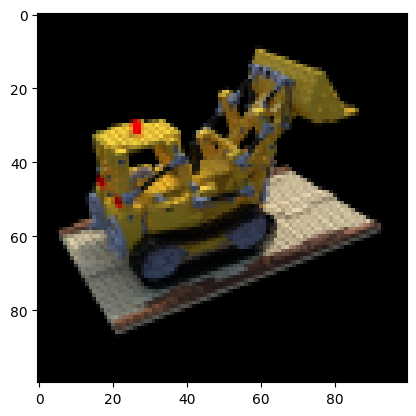

In [25]:
plt.imshow(data.sample_testset()[0].detach().cpu().numpy())
plt.show()

0.17011531814932823


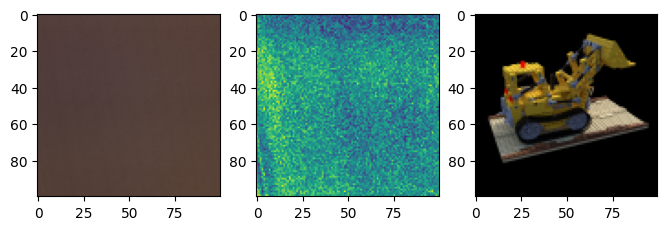

0.06063743911683559


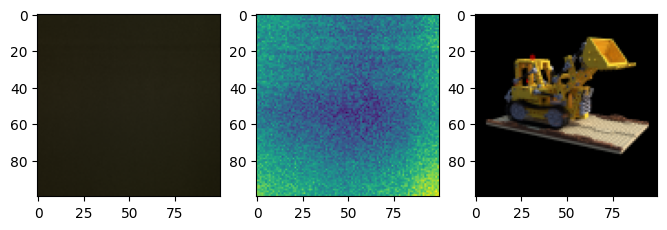

0.058523811362683774


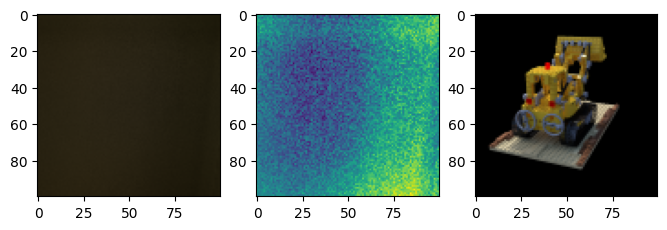

0.053831640630960464


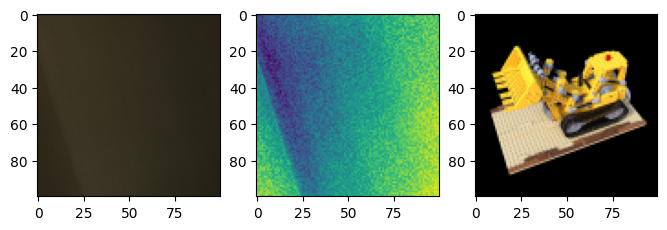

0.061805288307368755


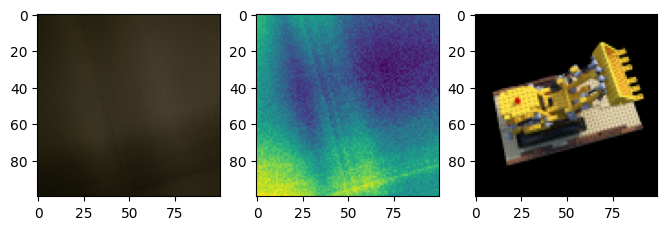

0.052439056262373926


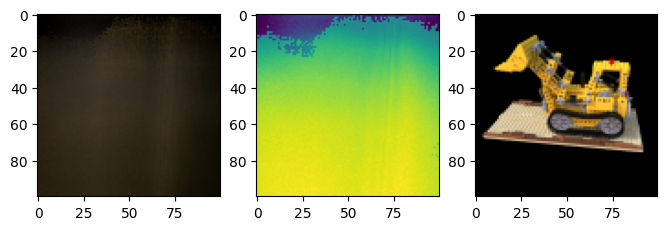

0.038827737346291545


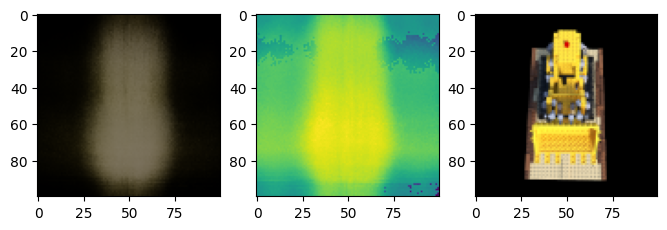

0.027376325093209742


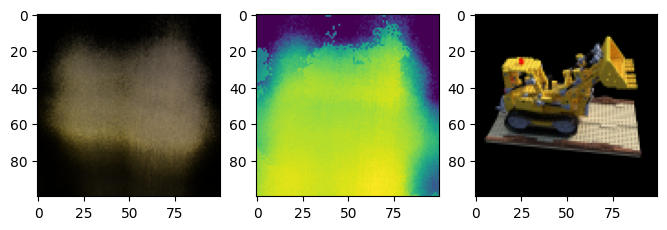

0.025807732343673707


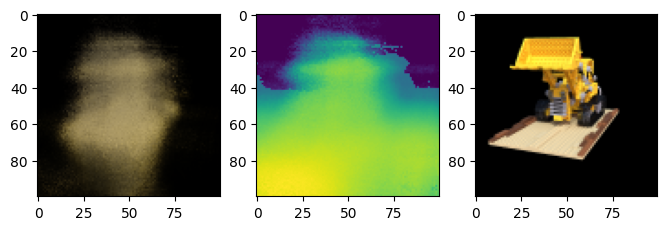

0.02322778068482876


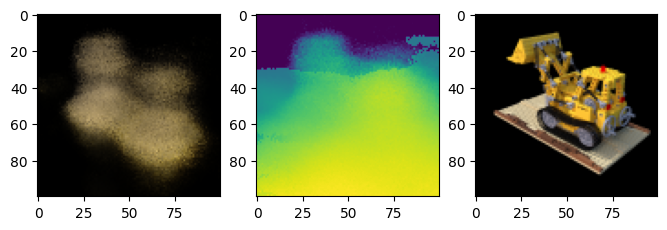

0.02436804637312889


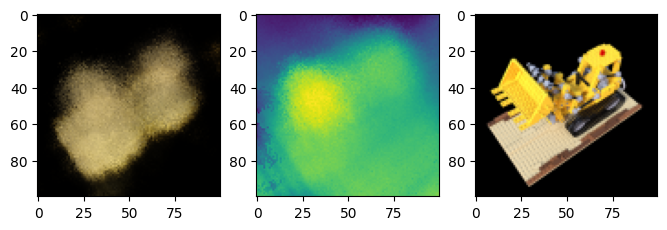

0.022835007067769766


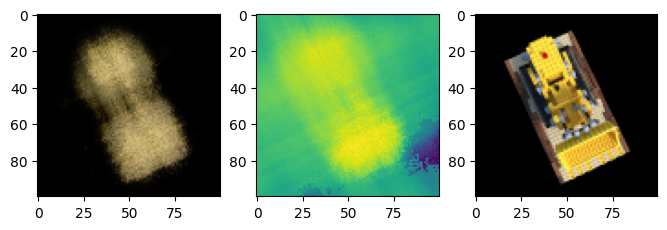

0.02074987031519413


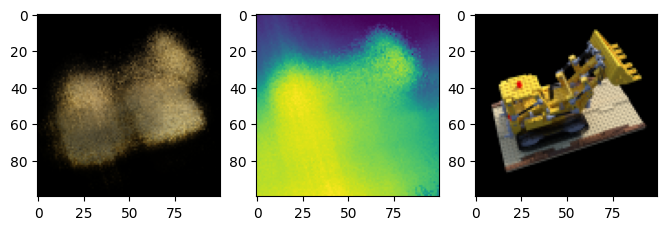

0.019012590758502482


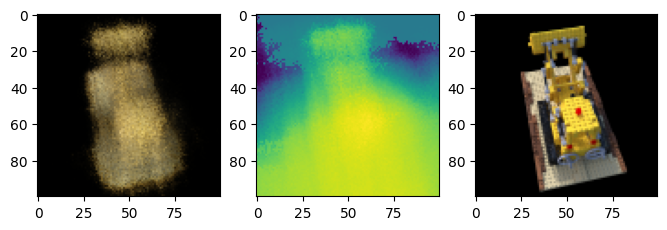

0.016558398194611072


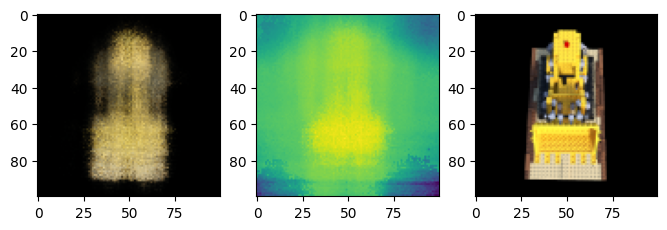

0.01664909180253744


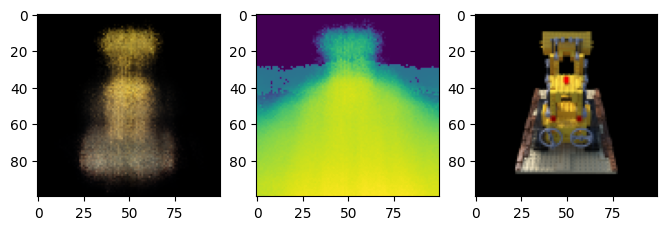

0.01601119985803962


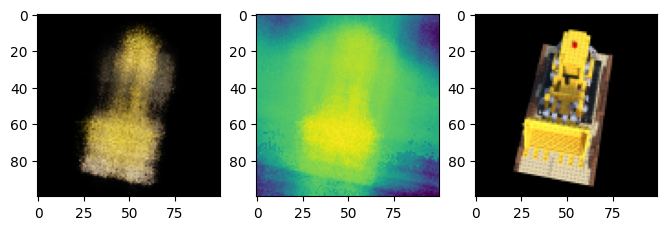

0.01531306242570281


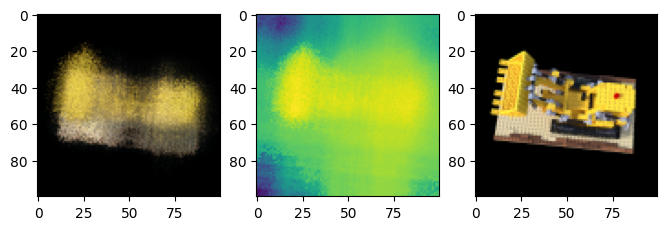

0.01507085759192705


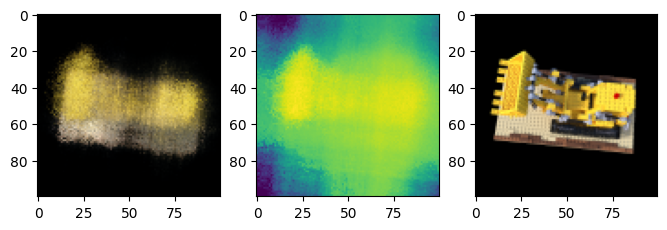

0.014621620886027814


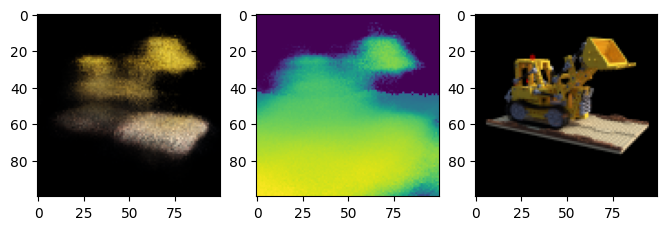

Done!


In [26]:

loss_history = []
cum_loss = 0.
for i in range(config.num_iters):
    (tgt_img,
        tgt_pose) = data.sample_trainset()
    rgb_predicted, _ = infer_rgb(tgt_pose,
                                    **infer_kwargs)
    loss = F.mse_loss(
        rgb_predicted,
        tgt_img,
    )
    cum_loss += loss.item()
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    if i % display_every == display_every-1:
        print(cum_loss/display_every)
        loss_history.append(cum_loss/display_every)
        cum_loss = 0.
        rendering_test(config, data, nerf_model)

print('Done!')